### 03 Konvoluce

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def get_hist(img, name):
    plt.ioff()
    plt.figure(figsize=(12,5))
    fig = plt.hist(img.flatten(),bins=256, range=(0,255), color = "k")
    plt.axis('off')
    plt.show()

def a_fft(img, radius = 200):
    print("img shape", img.shape)
    
    a, b = img.shape
    if(a%2 != 0):
        img = img[:-1,:]
    if(b%2 != 0):
        img = img[:,1:]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    # calculate amplitude spectrum
    mag_spec = 20*np.log(np.abs(fshift))
    print("ft shape", f.shape)
    print("center point ", (f.shape[0]//2,f.shape[1]//2))
    
    r = f.shape[0]//2        # number of rows/2
    c = f.shape[1]//2        # number of columns/2   
    p = 3                         
    n = 1                   # to suppress all except for the DC component       
    fshift2 = np.copy(fshift)


    # calculate new amplitude spectrum
    mag_spec2 = 20*np.log(np.abs(fshift2))
    inv_fshift = np.fft.ifftshift(fshift2)
    # reconstruct image
    img_recon = np.real(np.fft.ifft2(inv_fshift))
    

    plt.figure(figsize=(10,6))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(mag_spec, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    return img_recon

In [3]:
def load_image(path):
    im = cv2.imread("./imgs/"+path)
    return im

def save_image(img, path):
    cv2.imwrite("./results/"+path, img)

In [4]:
lena = load_image("lena_b.png")
marlon = load_image("marlon.jpg")
peppers = load_image("peppers.png")

In [85]:
def gaussian(sigma, k):
    v = []
    for i in range(k):
        l = i - k//2
        g = (1./np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(l*l) / (2 * (sigma**2)))
        v.append(g)
    v /= sum(v)
    return v

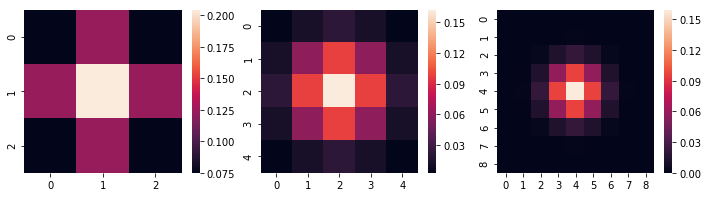

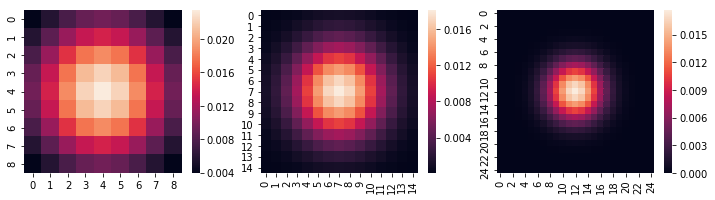

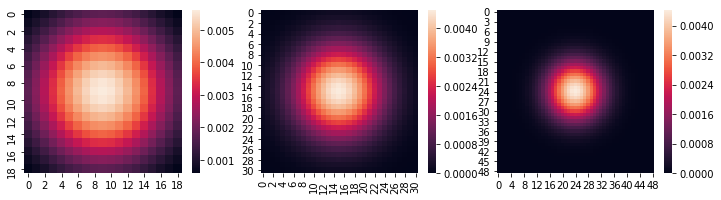

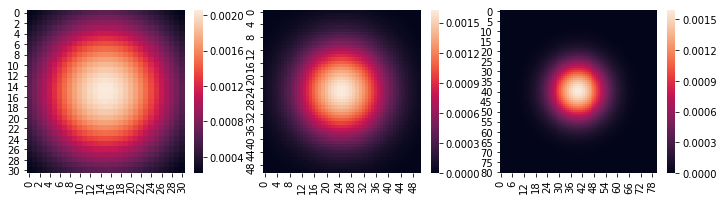

In [90]:
### choosing sigma
for s in [1,3,6,10]:
    kers = []
    for k in [s*3,s*5,s*8]:
        #print(s,k)
        k += k%2==0 and 1 or 0
        v = gaussian(s,k)
        #plt.plot(v)
        ker = np.outer(v,v)
        kers.append(ker)
        
    f,axes = plt.subplots(1,3,figsize=(12, 3))
    sns.heatmap(kers[0],ax=axes[0])
    sns.heatmap(kers[1],ax=axes[1])
    sns.heatmap(kers[2],ax=axes[2])
    plt.show()

In [51]:
def convolution(img,k,sigma):
    n,m,c = img.shape
    final = np.zeros((n,m,c))
    half = k//2
    
    # get kernel vectors (since gaussian is symmetrical they are identical)
    v = []
    
    for i in range(k):
        l = i - half
        g = (1./np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(l*l) / (2 * (sigma**2)))
        v.append(g)

    v /= sum(v)
    
    for channel in range(c):
        # adding padding to edges
        padded = np.pad(img[:,:,channel].copy(), half, 'reflect')
        d,e = padded.shape
        
        im = img[:,:,channel].copy()
        
        #empty arrays for new data
        first = np.zeros((n,m))
        second = np.zeros((n,m))
        
        #row vector
        for (x,y), pix in np.ndenumerate(np.zeros((n,m))):
            pix_val = 0.0
            for e,k in enumerate(v):#vector 1 * original
                shift = e - half
                im_pos = abs(x-shift)
                if(im_pos >= n):
                    im_pos += (n - im_pos - 1) 
                
                pix_val +=  im[im_pos,y] * k
            first[x,y] = pix_val 

        #column vector
        for (x,y), pix in np.ndenumerate(np.zeros((n,m))):
            pix_val = 0.0
            for e,k in enumerate(v):#vector 2 * original
                shift = e - half
                im_pos = abs(y-shift)
                if(im_pos >= m):
                    im_pos += (m - im_pos - 1) 
                pix_val +=  first[x,im_pos] * k
            second[x,y] = pix_val 
        # cutting of padding
        final[:,:,channel] = second
    
    final = final.astype(int)
    return final

#### Runs

In [91]:
print("kernel sizes:")
for sigma in [3,5,10]:
    ker = 5*sigma
    ker += ker%2==0 and 1 or 0
    print(ker, end=" ")

kernel sizes:
15 25 51 

In [92]:
images = [lena, marlon]
names = ["lena", "marlon"]

for sigma in [3,5,10]:
    for im, name in zip(images, names):
        ker = 5*sigma
        ker += ker%2==0 and 1 or 0
        res = convolution(im, ker, sigma)
        save_image(res,name+" "+str(ker)+".jpg")

In [94]:
for sigma in [3,5,10]:
    ker = 5*sigma
    ker += ker%2==0 and 1 or 0
    res = convolution(peppers, ker, sigma)
    save_image(res,"peppers "+str(ker)+".jpg")

img shape (200, 200)
ft shape (200, 200)
center point  (100, 100)
img shape (200, 200)
ft shape (200, 200)
center point  (100, 100)


array([[ 63.,  63.,  63., ...,  81.,  81.,  81.],
       [ 63.,  63.,  63., ...,  81.,  81.,  81.],
       [ 63.,  63.,  63., ...,  81.,  81.,  81.],
       ...,
       [ 78.,  78.,  78., ..., 103., 105., 107.],
       [ 78.,  78.,  78., ..., 106., 108., 110.],
       [ 77.,  77.,  78., ..., 109., 111., 112.]])

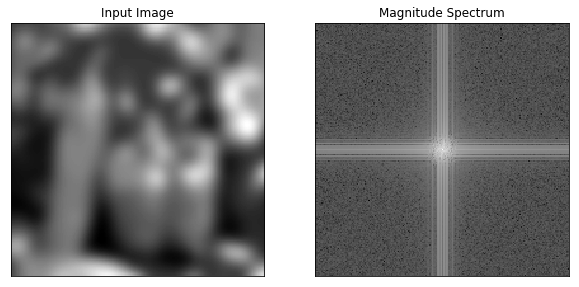

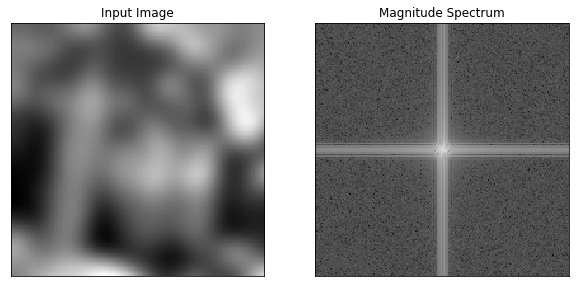

In [61]:
res = convolution(peppers, 121, 10)
vo10 = load_image("peppers_dzo.png")

a_fft(vo10[:,:,0])
a_fft(res[:,:,0])